**Import Data**

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# LOAD DATA (Check your file path!)
file_path = '/content/london_merged.csv'
df = pd.read_csv(file_path)

print("Data Loaded Successfully")

Data Loaded Successfully


**Data Cleaning and Hypothesis Testing**

In [7]:
# 1. CORRECT MAPPING
# create a dictionary
weather_map = {
    1: 'Clear',
    2: 'Cloudy',
    3: 'Cloudy',
    4: 'Cloudy',
    7: 'Rain',
    10: 'Rain',
    26: 'Snow',
    94: 'Ice'
}

# 2. Apply the translator to the whole column
# Creating a new column 'weather_label' by mapping the codes
df['weather_label'] = df['weather_code'].map(weather_map)

# 3. Filter the Data
# We only want rows where the label is EITHER 'Clear' OR 'Rain'
df_analysis = df[df['weather_label'].isin(['Clear', 'Rain'])].copy()

# 4. Create two piles of data
# pile 1: All the rows where it is Clear
clear_demand = df_analysis[df_analysis['weather_label'] == 'Clear']['cnt']
# pile 2: All the rows where it is Rain
rain_demand = df_analysis[df_analysis['weather_label'] == 'Rain']['cnt']

# 5. Calculate the Average (Mean)
avg_clear = clear_demand.mean()
avg_rain = rain_demand.mean()

# 6. Calculate the percent Drop
drop_percentage = ((avg_clear - avg_rain) / avg_clear) * 100

print(f"--- SUMMARY ---")
print(f"Avg Demand (Clear): {avg_clear:.0f}")
print(f"Avg Demand (Rain):  {avg_rain:.0f}")
print(f"Demand Drop: {drop_percentage:.1f}%")


# The Hypothesis Test (Two-Sample T-Test)
# equal_var=False because we assume the variance of sunny/rainy days is different (Welch's Test)
t_stat, p_val = stats.ttest_ind(clear_demand, rain_demand, equal_var=False)

print(f"--- HYPOTHESIS TEST RESULTS ---")
print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_val:.10f}")

if p_val < 0.05:
    print("REJECT Null Hypothesis: Rain statistically impacts demand.")
else:
    print("FAIL TO REJECT: The difference might be random chance.")

--- SUMMARY ---
Avg Demand (Clear): 1162
Avg Demand (Rain):  712
Demand Drop: 38.7%
--- HYPOTHESIS TEST RESULTS ---
T-Statistic: 20.1396
P-Value: 0.0000000000
REJECT Null Hypothesis: Rain statistically impacts demand.


**Analysis and Modelling**

In [8]:
# 1. WEEKEND VS WEEKDAY ANALYSIS

# Filter rows where Weather is Rain AND (Is_Weekend is True)
weekend_rain = df_analysis[(df_analysis['weather_label'] == 'Rain') & (df_analysis['is_weekend'] == 1)]['cnt']

# Filter rows where Weather is Clear AND (Is_Weekend is True)
weekend_clear = df_analysis[(df_analysis['weather_label'] == 'Clear') & (df_analysis['is_weekend'] == 1)]['cnt']

# Filter rows where Weather is Rain AND (Is_Weekend is False)
weekday_rain = df_analysis[(df_analysis['weather_label'] == 'Rain') & (df_analysis['is_weekend'] == 0)]['cnt']

# Filter rows where Weather is Clear AND (Is_Weekend is False)
weekday_clear = df_analysis[(df_analysis['weather_label'] == 'Clear') & (df_analysis['is_weekend'] == 0)]['cnt']



# Calculate the Drop %
weekend_drop = ((weekend_clear.mean() - weekend_rain.mean()) / weekend_clear.mean()) * 100
weekday_drop = ((weekday_clear.mean() - weekday_rain.mean()) / weekday_clear.mean()) * 100

print(f"--- DEEPER INSIGHT ---")
print(f"Weekend Demand Drop: {weekend_drop:.1f}%")
print(f"Weekday Demand Drop: {weekday_drop:.1f}%")

if weekend_drop > weekday_drop:
    print("Insight: Rain kills WEEKEND demand (Leisure riders stay home).")
else:
    print("Insight: Rain kills WEEKDAY demand.")

# 2. COST SAVINGS ASSUMPTION MODEL
avg_staff = 50
hourly_wage = 15  # £15/hr
hours_per_day = 8
rainy_days_per_month = 10

staff_reduction = avg_staff * (drop_percentage / 100)
monthly_savings = staff_reduction * hourly_wage * hours_per_day * rainy_days_per_month

print(f"\n--- BUSINESS IMPACT ---")
print(f"Recommended Staff Cut: -{int(staff_reduction)} people on rainy days")
print(f"Potential Monthly Savings: £{monthly_savings:,.0f}")


--- DEEPER INSIGHT ---
Weekend Demand Drop: 45.4%
Weekday Demand Drop: 36.1%
 Insight: Rain kills WEEKEND demand (Leisure riders stay home).

--- BUSINESS IMPACT ---
Recommended Staff Cut: -19 people on rainy days
Potential Monthly Savings: £23,232


**Visualization**

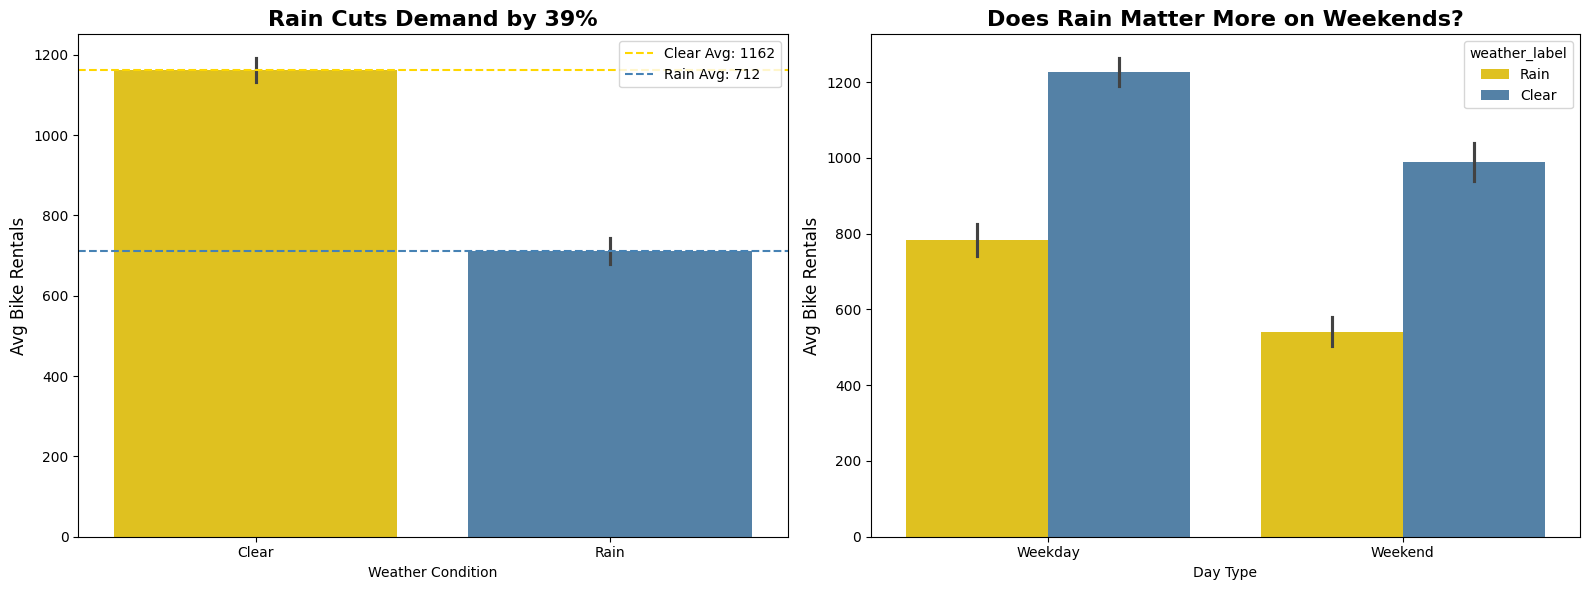

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: The Drop
sns.barplot(
    x='weather_label',
    y='cnt',
    data=df_analysis,
    hue='weather_label',
    palette=['#FFD700', '#4682B4'],
    legend=False,
    ax=axes[0]
)
axes[0].set_title(f'Rain Cuts Demand by {drop_percentage:.0f}%', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Avg Bike Rentals', fontsize=12)
axes[0].set_xlabel('Weather Condition')

# Add the dashed lines for reference
axes[0].axhline(y=avg_clear, color='#FFD700', linestyle='--', label=f'Clear Avg: {avg_clear:.0f}')
axes[0].axhline(y=avg_rain, color='#4682B4', linestyle='--', label=f'Rain Avg: {avg_rain:.0f}')
axes[0].legend()

# Plot 2: Weekend vs Weekday
sns.barplot(
    x='is_weekend',
    y='cnt',
    hue='weather_label',
    data=df_analysis,
    palette=['#FFD700', '#4682B4'],
    ax=axes[1]
)
axes[1].set_title('Does Rain Matter More on Weekends?', fontsize=16, fontweight='bold')
axes[1].set_ylabel('Avg Bike Rentals', fontsize=12)
axes[1].set_xlabel('Day Type')

# x-axis labels
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Weekday', 'Weekend'])

plt.tight_layout()
plt.show()

In [12]:

print(f"Clear Days (Group 1): Mean={clear_demand.mean():.0f}, StdDev={clear_demand.std():.0f}, N={clear_demand.count()}")
print(f"Rainy Days (Group 2): Mean={rain_demand.mean():.0f}, StdDev={rain_demand.std():.0f}, N={rain_demand.count()}")

Clear Days (Group 1): Mean=1162, StdDev=1187, N=6150
Rainy Days (Group 2): Mean=712, StdDev=763, N=2155
